In [8]:
import xml.etree.ElementTree as ET
import requests
import json
import numpy as np


def get_images_from_query(topic_dict):
    """
    Getting list of top-100 images based on a query
    """
    URL = "http://localhost:8003/images/"
    PARAMS = {
        "query":
            {
                "before": topic_dict["before"],
                "beforewhen": topic_dict["beforewhen"],
                "after": topic_dict["after"],
                "afterwhen": topic_dict["afterwhen"],
                "current": topic_dict["current"],
                "isQuestion": False,
                "info": None
            },
        "gps_bounds": None,
        "starting_from": 0,
        "share_info": False,
        "size": 200
    }
    response = requests.post(URL, data=json.dumps(PARAMS), headers={'Content-Type': 'application/json'})
    data = response.json()
    images = [triplet["current"] for triplet in data["results"]]
    return images

# LSC22

In [9]:
# Read LSC22 queries
end_id = "LSC-121"
queries = {}
with open("LSC22queries.txt") as f:
    all_lines = f.readlines()
    all_lines = [line.strip() for line in all_lines]
    print(len(all_lines))
    i = 0
    id = ""
    hints = []
    while i < len(all_lines):
        line = all_lines[i]
        if line.startswith("LSC"):
            id = line
            hints = all_lines[i+1 : i+7] #6 hints
            targets = []
            i = i + 7
            while all_lines[i].strip():
                targets.append(all_lines[i])
                i += 1
            queries[id] = {"hints": hints, 
                           "targets": targets}
            if id == end_id:
                break
        i += 1

293


In [10]:
# rewritten_queries = []
# for query in queries.values():
#     new_query = []
#     last_hint = ""
#     for hint in query["hints"]:
#         new_last_hint = hint
#         hint = hint.replace(last_hint, "")
#         last_hint = new_last_hint.strip('. ')
#         new_query.append({"current": hint, "before": "", "beforewhen": None, "after": "", "afterwhen": None})
#     rewritten_queries.append(new_query)
# json.dump(rewritten_queries, open("LSC22_split.json", "w"))
rewritten_queries = json.load(open("LSC22_split.json"))

## Sending requests

In [235]:
cached = {}

In [236]:
from collections import defaultdict
from tqdm.auto import tqdm
stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
mod_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
printed = defaultdict(list)
ave_lengths = []
ave_results = []
rewritten_queries = json.load(open("LSC22_split.json"))
targets = [query["targets"] for query in queries.values()]
for i, query in tqdm(enumerate(rewritten_queries), total=len(rewritten_queries)):
    last_hint = ""
    for j, hint in enumerate(query):
        hint["current"] = last_hint + hint["current"]
        hint["current"] = hint["current"].replace("..", ".")
        last_hint = hint["current"]
        try:
            if f"{i}_hint{j}" in cached:
                results = cached[f"{i}_hint{j}"]
            else:
                results = get_images_from_query(hint)
                cached[f"{i}_hint{j}"] = results
        except:
            results = []
        ave_results.append(len(results))
        ave_lengths.extend([len(scene) for scene in results])
        for k in [1, 3, 5, 10, 20, 50]:
            idx = []
            all_images = []
            for scene in results[:k]:
                all_images.extend([image[0].split(".")[0].split("/")[-1] for image in scene])
            matches = set.intersection(set(all_images), set(targets[i]))
            if len(matches) == 0:
                if j > 0:
                    if stats[i][j-1][k] > 0 and j not in printed[i]:
                        printed[i].append(j)
                    mod_stats[i][j][k] = mod_stats[i][j-1][k]
            else:
                stats[i][j][k] = 1
                mod_stats[i][j][k] = 1

  0%|          | 0/14 [00:00<?, ?it/s]

In [189]:
np.array(ave_lengths).mean()

2.786509135870312

In [190]:
np.array(ave_results).mean()

86.6547619047619

In [191]:
keys = list(queries.keys())
for i in printed:
    print("=" * 80)
    print(i)
    for j in printed[i]:
        print(j, queries[keys[i]]["hints"][j])

0
4 I was praying to small golden Buddha in a tunnel. There were plants and offerings around the Buddha. It was inside of a tourist park with a large ornamental tower. It was in September 2019
1
3 I think it was the second time I visited the house with the stone shed / hovel.  The shed was under green trees on a beautiful sunny day. It takes 2 hours to drive there and two hours to drive back home.
3
2 Mother Mary, pray for us! A religious image in front of a window on a Saturday morning
4
3 After a short relaxing walk, I reached the edge of a lake. There were mountains and trees, but very few people. It was a cold day
12
3 Preaching to a full room. My hands were out in front of me, I was speaking to a room of about 200 people seated at dinner tables.
13
3 Buying hand soaps in a shop called Molton Brown in the early morning. I was at an outside shopping mall and driving a long way


In [237]:
import numpy as np
for hint_j in range(6):
    print(hint_j + 1, end=" & ")
    for hit_k in [1, 3, 5, 10, 20, 50]:
        result_hit = []
        for i in range(len(queries)):
            result_hit.append(stats[i][hint_j][hit_k])
        print(f"{np.mean(result_hit):0.2f}", end=" & ")
    print("\\\\")

1 & 0.29 & 0.43 & 0.43 & 0.50 & 0.57 & 0.64 & \\
2 & 0.36 & 0.57 & 0.57 & 0.57 & 0.64 & 0.64 & \\
3 & 0.43 & 0.64 & 0.71 & 0.79 & 0.79 & 0.79 & \\
4 & 0.43 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & \\
5 & 0.57 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & \\
6 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & \\


In [238]:
len(queries)


14

In [239]:
for hint_j in range(6):
    print(hint_j + 1, end=" & ")
    for hit_k in [1, 3, 5, 10, 20, 50]:
        mod_result_hit = []
        for i in range(len(queries)):
            mod_result_hit.append(mod_stats[i][hint_j][hit_k])
        print(f"{np.mean(mod_result_hit):0.2f}", end=" & ")
    print("\\\\")


1 & 0.29 & 0.43 & 0.43 & 0.50 & 0.57 & 0.64 & \\
2 & 0.36 & 0.64 & 0.64 & 0.64 & 0.71 & 0.71 & \\
3 & 0.57 & 0.71 & 0.79 & 0.86 & 0.86 & 0.86 & \\
4 & 0.57 & 0.79 & 0.79 & 0.86 & 0.86 & 0.86 & \\
5 & 0.71 & 0.79 & 0.79 & 0.86 & 0.86 & 0.86 & \\
6 & 0.79 & 0.79 & 0.79 & 0.86 & 0.86 & 0.86 & \\


In [240]:
for hint_j in range(6):
    for hit_k in [3]:
        mod_result_hit = []
        for i in range(len(queries)):
            mod_result_hit.append(mod_stats[i][hint_j][hit_k])
        print(f"{np.mean(mod_result_hit):0.2f}", end=" & ")
    print("\\\\")


0.43 & \\
0.64 & \\
0.71 & \\
0.79 & \\
0.79 & \\
0.79 & \\


# Visualisation

In [123]:
import pandas as pd
import numpy as np
def parse_results(latex_str, model="cluster"):
    all_lines = []
    hint = 1
    for line in latex_str.split("\\"):
        if line:
            line = line.strip().split("&")
            for i, k in enumerate([1, 3, 5, 10, 20, 50]):
                all_lines.append([model, hint, k, float(line[i + 1])])
        hint += 1
    return pd.DataFrame(all_lines, columns=["Model", "hint", "K", "score"])
        
        
df = parse_results("""1 & 0.43 & 0.50 & 0.50 & 0.64 & 0.64 & 0.86 & 0.50\\
2 & 0.57 & 0.71 & 0.79 & 0.79 & 0.86 & 0.93 & 0.71\\
3 & 0.64 & 0.79 & 0.79 & 0.86 & 0.86 & 0.86 & 0.86\\
4 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.86\\
5 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.86\\
6 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.86\\""", "Cluster")

df = pd.concat([df, parse_results("""1 & 0.29 & 0.43 & 0.43 & 0.50 & 0.57 & 0.64 & 0.43\\
2 & 0.36 & 0.57 & 0.57 & 0.57 & 0.64 & 0.64 & 0.64\\
3 & 0.43 & 0.64 & 0.71 & 0.79 & 0.79 & 0.79 & 0.71\\
4 & 0.43 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.79\\
5 & 0.57 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.79\\
6 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.79\\""", "WTransf")])

df = pd.concat([df, parse_results("""1 & 0.07 & 0.07 & 0.07 & 0.07 & 0.07 & 0.21 & 0.07\\
2 & 0.07 & 0.07 & 0.07 & 0.07 & 0.29 & 0.43 & 0.07\\
3 & 0.07 & 0.14 & 0.21 & 0.29 & 0.36 & 0.43 & 0.14\\
4 & 0.07 & 0.07 & 0.21 & 0.43 & 0.57 & 0.57 & 0.14\\
5 & 0.21 & 0.21 & 0.29 & 0.36 & 0.50 & 0.57 & 0.29\\
6 & 0.21 & 0.21 & 0.21 & 0.29 & 0.29 & 0.29 & 0.36\\""", "Transf")])

df = pd.concat([df, parse_results("""1 & 0.43 & 0.50 & 0.50 & 0.64 & 0.71 & 0.93 & 0.50 \\
2 & 0.57 & 0.79 & 0.79 & 0.79 & 0.86 & 0.93 & 0.79\\
3 & 0.64 & 0.79 & 0.86 & 0.86 & 0.86 & 0.86 & 0.86\\
4 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.64 & 0.86\\
5 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.86\\
6 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.57 & 0.86\\""", "Mean")])


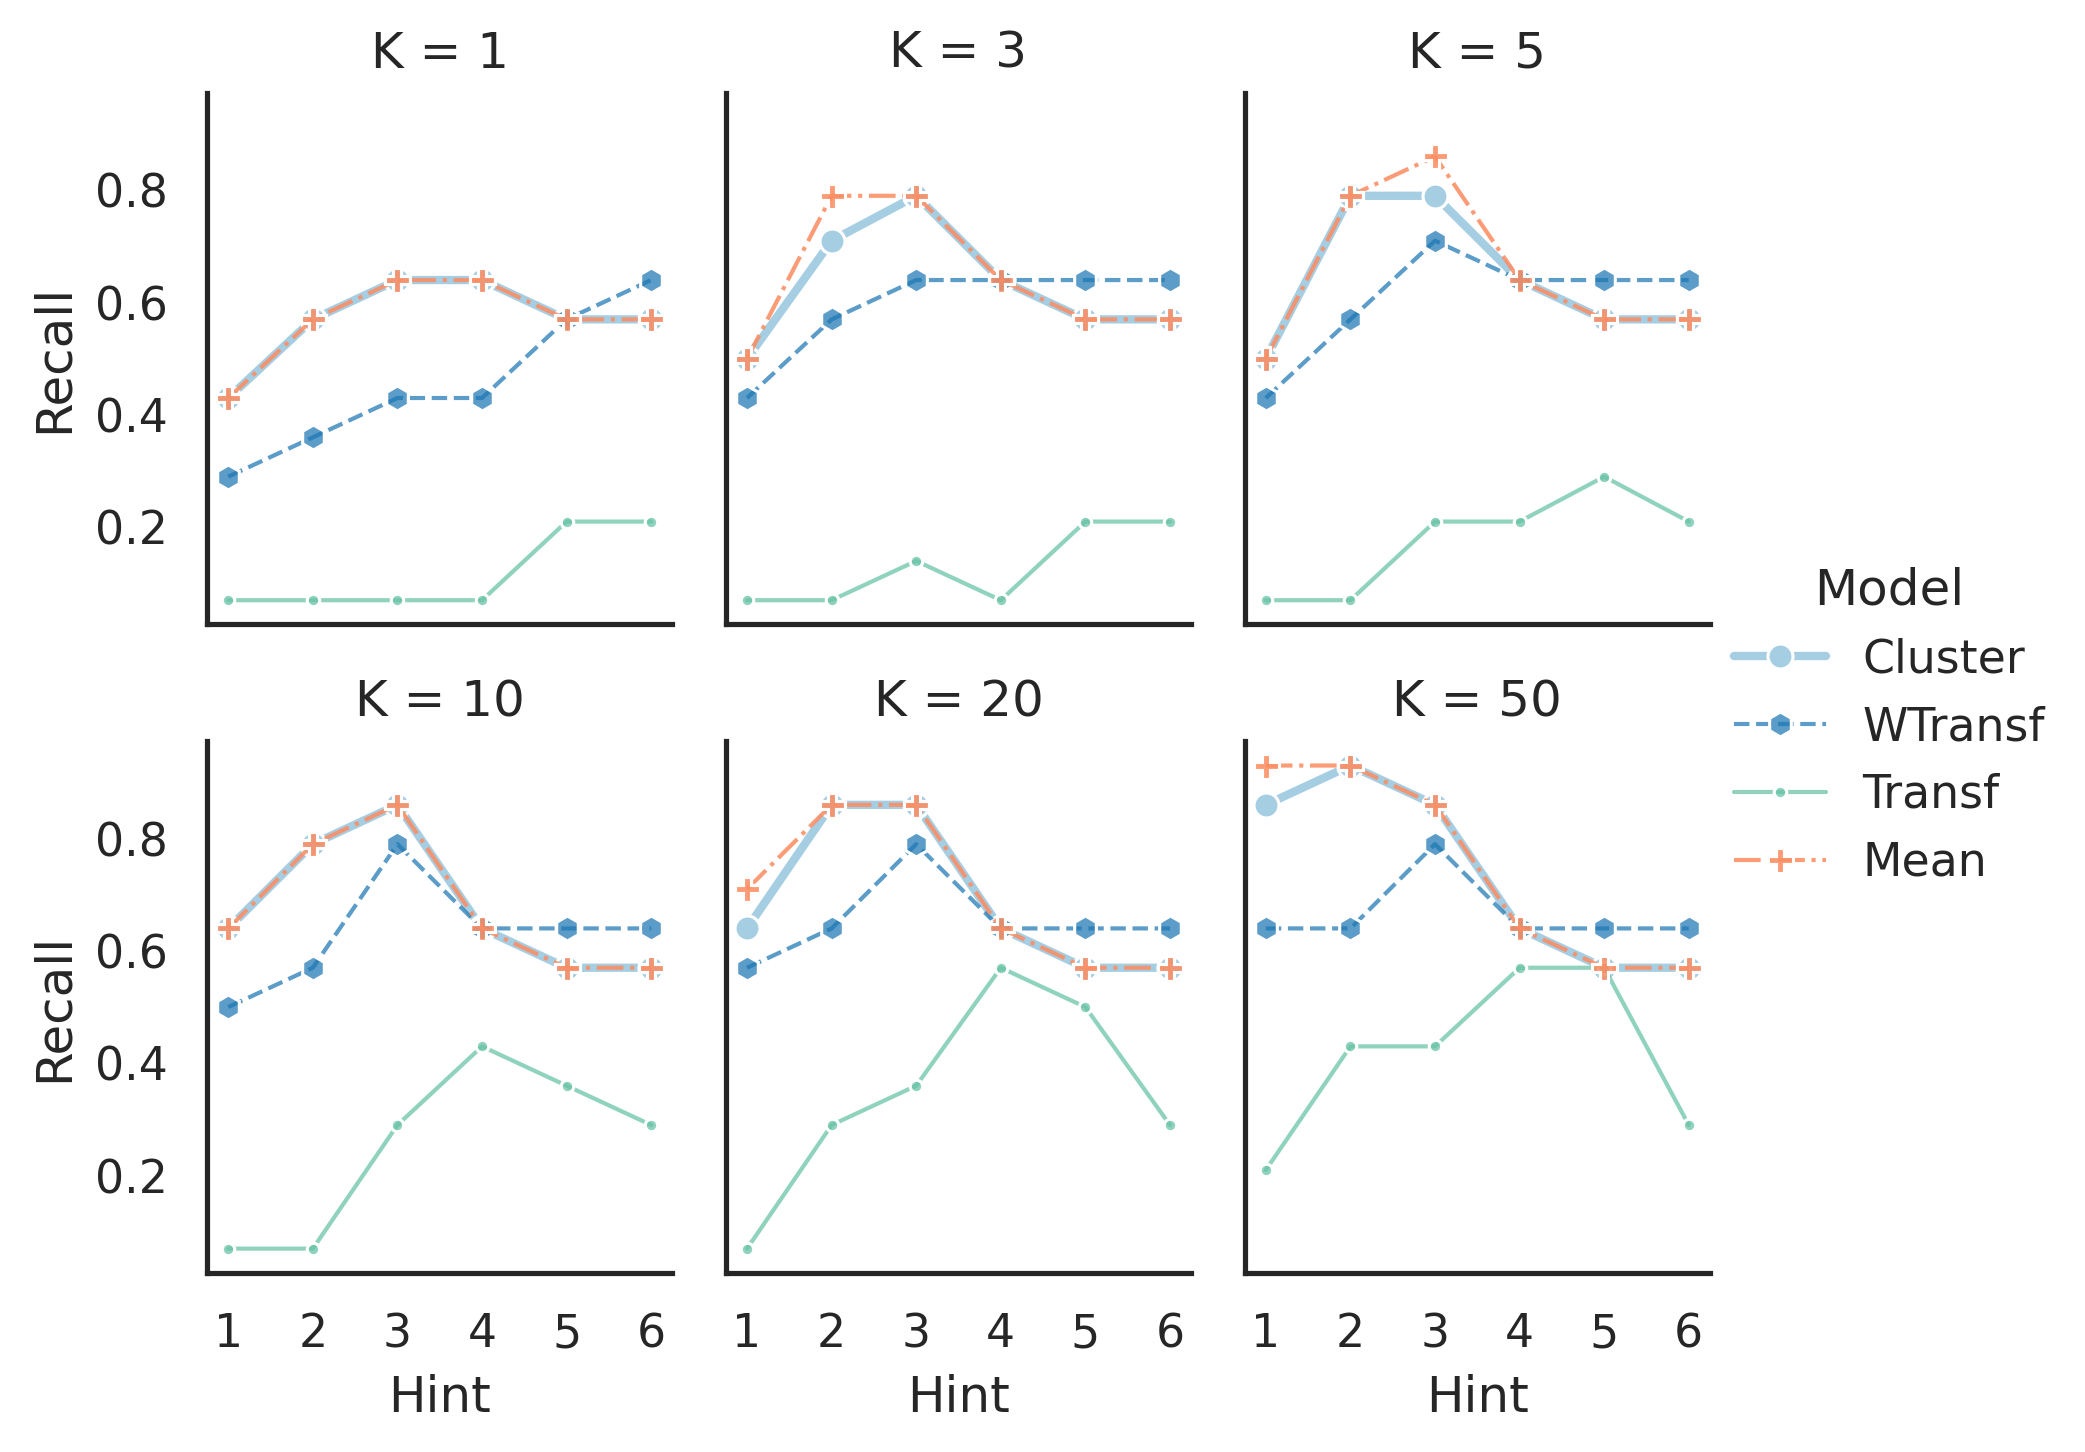

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
# reset the seaborn styles

colors = """#a6cee3
#1f78b4BB
#66c2a5BB
#fc8d62DD"""

d = {'color': colors.split("\n"), 
     "ls": ["-", "--", "-", '-.'], 
     "linewidth": [2, 1, 1, 1], 
     "marker": ["o", "h", ".", "P"]}

g = sns.FacetGrid(df, col="K", hue="Model", col_wrap=3, height=2.5, aspect=0.8, hue_kws=d)
sns.set_theme(style="white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# sns.set(font_scale=2)
g.map(sns.lineplot, "hint", "score")
g.set_axis_labels("Hint", "Recall")
g.set(xticks=[1,2,3,4,5,6])
g.set_xticklabels(([1,2,3,4,5,6]))
g.fig.tight_layout()
g.add_legend()

# LSC21

In [2]:
data = json.load(open('LSC21queries.json'))
queries = data["queries"]
targets = data["targets"]

In [3]:
len(queries)

23

In [4]:
rewritten_queries = []
for query in queries.values():
    new_query = []
    last_hint = ""
    for hint in query:
        new_last_hint = hint
        hint = hint.replace(last_hint, "")
        last_hint = new_last_hint.strip('. ')
        new_query.append({"current": hint, "before": "", "beforewhen": None, "after": "", "afterwhen": None})
    rewritten_queries.append(new_query)
json.dump(rewritten_queries, open("rewritten_queries_clip.json", "w"))

In [3]:
null = None
results = get_images_from_query(  {
            "current": "Going into \"Northside Shopping Centre\"",
            "before": "I am driving to the shopping centre from work",
            "beforewhen": null,
            "after": "I am there to get new keys",
            "afterwhen": null
        })
for k in [1, 3, 5, 10, 20, 50, 100]:
    idx = []
    all_images = []
    for scene in results[:k]:
        all_images.append(scene[0])
    matches = set.intersection(set(all_images), set(targets[1]))
    if len(matches) == 0:
        print(0, end='      ')
    else:
        print(1, end='      ')

0      1      1      1      1      1      1      

In [4]:
from collections import defaultdict
rewritten_queries = json.load(open("rewritten_queries.json"))
#stats[query_i][hint_j][hit_k]
stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
mod_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
printed = []
for i, query in enumerate(rewritten_queries):
    for j, hint in enumerate(query):
        try:
            results = get_images_from_query(hint)
        except:
            results = []
        for k in [1, 3, 5, 10, 20, 50, 100]:
            idx = []
            all_images = []
            for scene in results[:k]:
                all_images.append(scene[0])
            matches = set.intersection(set(all_images), set(targets[i]))
            if len(matches) == 0:
                stats[i][j][k] = 0
                if j > 0:
                    if mod_stats[i][j-1][k] > 0:
                        if (i, j) not in printed:
                            printed.append((i,j))
                            print(hint)
                    mod_stats[i][j][k] = mod_stats[i][j-1][k]
            else:
                stats[i][j][k] = 1
                mod_stats[i][j][k] = 1

{'current': 'Birds in a cage, a yellow one on the lower left.', 'before': '', 'beforewhen': None, 'after': 'There is one box with a small, green bettle old car.', 'afterwhen': None}
{'current': 'Birds in a cage, a yellow one on the lower left. ', 'before': '', 'beforewhen': None, 'after': 'There is one box with a small, blue bettle old car.', 'afterwhen': None}
{'current': 'I put a sign on my door', 'before': '', 'beforewhen': None, 'after': '', 'afterwhen': None}
{'current': 'I am lost and looking for directions on a street, close to a restaurant called "Maple Leaf" evening Wexford 2015', 'before': 'driving Dublin', 'beforewhen': 3, 'after': '', 'afterwhen': None}
{'current': 'Colleague in my office; she is carrying a large paper envelope full of documents. The envelope looked very heavy ', 'before': '', 'beforewhen': None, 'after': '', 'afterwhen': None}
{'current': 'Colleague in my office; she is  carrying a large paper envelope full of documents. The envelope looked very heavy. She

In [32]:
import numpy as np
for hint_j in range(6):
    print(hint_j + 1, end=" & ")
    for hit_k in [1, 3, 5, 10, 20, 50, 100]:
        result_hit = []
        for i in stats:
            result_hit.append(stats[i][hint_j][hit_k])
        print(f"{np.mean(result_hit):0.2f}", end=" & ")
    print("\\\\")

1 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
2 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
3 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
4 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
5 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
6 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\


In [33]:
for hint_j in range(6):
    print(hint_j + 1, end=" & ")
    mod_result_hit = []
    for hit_k in [1, 3, 5, 10, 20, 50, 100]:
        for i in stats:
            mod_result_hit.append(mod_stats[i][hint_j][hit_k])
#                 {np.mean(mod_result_hit):0.4f}
        print(f"{np.mean(mod_result_hit):0.2f}", end=" & ")
    print("\\\\")

1 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
2 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
3 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
4 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
5 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\
6 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & \\


In [9]:
import xml.etree.ElementTree as ET

ntcir13 = '/home/tlduyen/LQA/BDG/ntcir-13.xml'

descriptions = []
tree = ET.parse(ntcir13)
root = tree.getroot()
for child in root:
    for j in child:
        if j.tag == "description":
            descriptions.append("I " + j.text.split('I', 1)[1].strip('. ,'))

In [10]:
descriptions

['I was eating lunch',
 'I was gardening in my home',
 'I was visiting a castle at night',
 'I was drinking coffee in a cafe',
 'I was outside at sunset',
 'I visited a graveyard',
 'I was lecturing to a group of people in a classroom environment',
 'I was grocery shopping',
 'I worked at home after 11pm',
 'I was working on the computer at my office desk',
 'I was cooking at home',
 'I was travelling by airplane',
 'I was making juice using fruit and/or vegetable.s',
 'I was walking by the sea and taking photos',
 'I had more than one beer in a bar',
 'I was attending a show in an ancient Greek amphitheatre',
 'I was being recorded for a television show',
 'I was working in a coffee shop',
 'I was painting the walls at home',
 'I was eating Pasta',
 'I was exercising at home on a green mat',
 'I was looking at Benbulbin mountain',
 'I was hiking on a mountain',
 'I was looking at or sitting beside a turtle tank']

In [3]:
from collections import defaultdict
ground_truth = defaultdict(set)
with open('/home/tlduyen/LQA/BDG/NTCIR13_Lifelog2_LSAT_gt.csv') as f:
    for line in f.readlines():
        "u1_2016-08-16_111256_2, 1"
        image, topic = line.split(', ')
        ground_truth[int(topic)].add(image[3:-2].replace('-', ''))

In [2]:
alternatives = """eating lunch
gardening in my home
visiting a castle at night
drinking coffee in a cafe
outside at sunset
visited a graveyard
lecturing to a group of people in a classroom environment
grocery shopping
worked at home late at night
working on the computer at my office desk""".split('\n')

In [143]:
alternatives = """I am eating lunch
I am gardening in my home
I am visiting a castle at night
I am drinking coffee in a cafe
I am outside at sunset
I am visiting a graveyard
I am lecturing to a group of people in a classroom environment
I am grocery shopping
I am working at home late at night
I am working on the computer at my office desk""".split('\n')

In [153]:
import pandas as pd
k = 10
final_results = []
for i in range(10):
    search_query = alternatives[i]
    try:
        results = get_images_from_query({"current": search_query, "before": "", "beforewhen": None, "after": "", "afterwhen": None})
    except:
        results = []
   
    all_images = []
    for scene in results[:k]:
        all_images.append(scene[0].split('.')[0].split('/')[-1].replace('_000', ''))
    if len(all_images) == 0:
        print(search_query)
        continue
    final_results.append(all_images)

In [155]:
score = []
for all_images, truth in zip(final_results, ground_truth.values()):
    gtp = 0
    n = 10
    p = 0
    matches = set.intersection(truth, all_images[:n])
    p = len(matches)/k
    score.append(p)
#     for i in range(n):
#         if all_images[i] in truth:
#             matches = set.intersection(truth, all_images[:i + 1])
#             p += len(matches)/(i+1)
#             gtp += 1 
#     if gtp == 0:
#         score.append(1.0)
#     else:
#         score.append(p/min(len(truth), n))
print(sum(score[:10])/10)
score[:10]

0.5599999999999998


[0.7, 0.2, 0.7, 0.6, 0.0, 0.7, 0.6, 0.9, 0.6, 0.6]

no object: 0.63, [0.8, 0.4, 0.8, 0.8, 0.0, 0.8, 0.5, 0.9, 0.7, 0.6]

present tense: 0.57, [0.7, 0.3, 0.7, 0.7, 0.0, 0.6, 0.6, 0.9, 0.8, 0.4]

past tense: 0.51, [0.2, 0.5, 0.8, 0.9, 0.0, 0.5, 0.6, 0.8, 0.7, 0.1]

In [165]:
# Wrong only
relevance_judgements = {
    1: [7],
    2: [4,5,6,7,8,9],
    3: [7,9],
    4: [7],
    5: [9,7,6,2],
    6: [],
    7: [3,5,6],
    8: [],
    9: [2, 5],
    10:[]
}

In [166]:
def AP(wrong_sub):
    subs = [i not in wrong_sub for i in range(10)]
    rel_so_far = 0
    sum = 0
    for i, sub in enumerate(subs):
        if sub:
            rel_so_far += 1
            sum += rel_so_far / (i + 1)
    if rel_so_far == 0:
        return 1
    return sum/10

def P_10(wrong_sub):
    subs = [i not in wrong_sub for i in range(10)]
    return sum(subs[:10])/10

score = []
for wrong_sub in relevance_judgements.values():
    score.append(AP(wrong_sub))
    
print(sum(score)/10)
score

0.7690039682539682


[0.8788888888888889,
 0.4,
 0.788888888888889,
 0.8788888888888889,
 0.505,
 1.0,
 0.5791666666666667,
 1.0,
 0.6592063492063491,
 1.0]

In [4]:
import pandas as pd
k = 10
final_results = []
for i in range(10):
    search_query = alternatives[i]
    try:
        results = get_images_from_query({"current": search_query, "before": "", "beforewhen": None, "after": "", "afterwhen": None})
    except:
        results = []
   
    all_images = []
    for scene in results[:k]:
        all_images.append(scene[0])
    if len(all_images) == 0:
        print(search_query)
        continue
    final_results.append(all_images)

In [170]:
final_results[2][:10]

['2016-08-23/20160823_210443_000.jpg',
 '2016-08-23/20160823_210046_000.jpg',
 '2016-08-23/20160823_210339_000.jpg',
 '2016-08-23/20160823_210235_000.jpg',
 '2016-08-23/20160823_210619_000.jpg',
 '2016-08-23/20160823_210411_000.jpg',
 '2016-08-23/20160823_210859_000.jpg',
 '2016-09-10/20160910_201843_000.jpg',
 '2016-08-23/20160823_210723_000.jpg',
 '2016-09-26/20160926_200947_000.jpg']

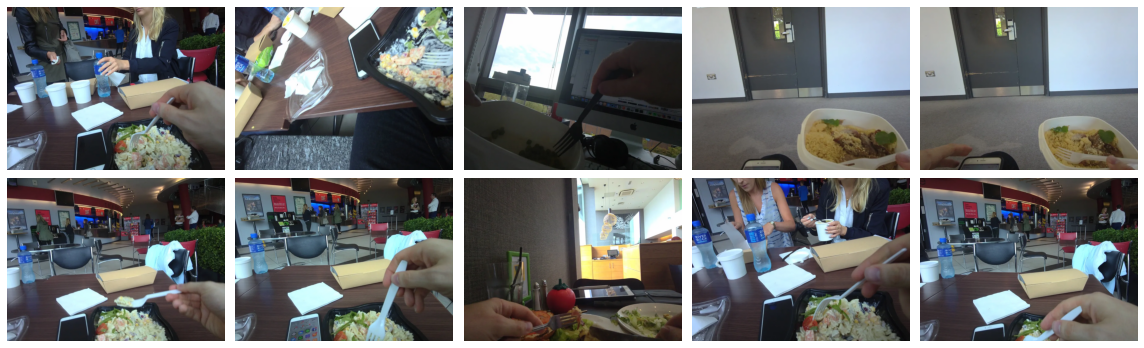

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display

plt.figure(figsize=(16, 5))
images = final_results[0][:10]
for i, filename in enumerate(images):
    try:
        image = Image.open("/home/tlduyen/webp_images/" + filename.split('.')[0] + ".webp").convert("RGB")

        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(image)
        ax.axis('off')
    except:
        print("Error in " + filename)
        continue
    
plt.tight_layout()

In [142]:
query = "outside at sunset"
truth = ground_truth[5]
try:
    results = get_images_from_query({"current": query, "before": "", "beforewhen": None, "after": "", "afterwhen": None})
except:
    results = []
all_images = []
for scene in results:
    all_images.append(scene[0].split('.')[0].split('/')[-1].replace('_000', ''))
k = 10
all_images = all_images[:k]
print([(i, image) for i,image in enumerate(all_images) if image not in truth])
matches = set.intersection(truth, all_images[:k])
p = len(matches)/k
p

[(0, '20160812_195451'), (1, '20160812_195846'), (2, '20160924_181832'), (3, '20160815_192246'), (4, '20160815_191617'), (5, '20160826_193928'), (6, '20160820_182841'), (7, '20160922_183610'), (8, '20160815_191938'), (9, '20160922_182620')]


0.0